In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import sklearn.metrics as sm
from sklearn.metrics import confusion_matrix
from sklearn import manifold
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image, display_png
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data
import numpy as np
from sklearn import manifold
import folium
from pyproj import Proj, transform
from pyproj import Transformer
import os
sns.set()

In [3]:
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

<h1> Objective </h1>
<blockquote>
    
Use K-Means clustering to cluster whisky distilleries by their tasting profile. Use the elbow or silhouette method to find the optimal number of clusters.
    
</blockquote>

<h2> Loading in dataset </h2>


In [4]:
whiskey_df = pd.read_csv('data/whisky.csv')

<h2> Examining the dataset </h2>


In [5]:
whiskey_df.head()

,RowID,Distillery,Body,Sweetness,Smoky,Medicinal,Tobacco,Honey,Spicy,Winey,Nutty,Malty,Fruity,Floral,Postcode,Latitude,Longitude
0,1,Aberfeldy,2,2,2,0,0,2,1,2,2,2,2,2,\tPH15 2EB,286580,749680
1,2,Aberlour,3,3,1,0,0,4,3,2,2,3,3,2,\tAB38 9PJ,326340,842570
2,3,AnCnoc,1,3,2,0,0,2,0,0,2,2,3,2,\tAB5 5LI,352960,839320
3,4,Ardbeg,4,1,4,4,0,0,2,0,1,2,1,0,\tPA42 7EB,141560,646220
4,5,Ardmore,2,2,2,0,0,1,1,1,2,3,1,1,\tAB54 4NH,355350,829140


<blockquote>
    From the above table we can see that we are given different attributes related to taste(body, sweetness, smoky, medicinal, tabacco, honey, picy, winey, nutty, malty, fruity, floral) and the location at which it's made. I will use these features to identify the simiarities between these whiskeys and place them in clusters.
    </blockquote>

In [6]:
whiskey_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   RowID       86 non-null     int64 
 1   Distillery  86 non-null     object
 2   Body        86 non-null     int64 
 3   Sweetness   86 non-null     int64 
 4   Smoky       86 non-null     int64 
 5   Medicinal   86 non-null     int64 
 6   Tobacco     86 non-null     int64 
 7   Honey       86 non-null     int64 
 8   Spicy       86 non-null     int64 
 9   Winey       86 non-null     int64 
 10  Nutty       86 non-null     int64 
 11  Malty       86 non-null     int64 
 12  Fruity      86 non-null     int64 
 13  Floral      86 non-null     int64 
 14  Postcode    86 non-null     object
 15  Latitude    86 non-null     int64 
 16  Longitude   86 non-null     int64 
dtypes: int64(15), object(2)
memory usage: 11.5+ KB


In [7]:
whiskey_df.isnull().sum()

RowID         0
Distillery    0
Body          0
Sweetness     0
Smoky         0
Medicinal     0
Tobacco       0
Honey         0
Spicy         0
Winey         0
Nutty         0
Malty         0
Fruity        0
Floral        0
Postcode      0
Latitude      0
Longitude     0
dtype: int64

<blockquote>
The data does not contain any null or incorrect value and can be used to model.
</blockquote>

<h2> Data Processing </h2>


In [8]:
whiskey_df.drop(['RowID',],inplace=True,axis=1)

<blockquote>
    Dropping RowID as I don't need it in order to model.
</blockquote>

<h2> Feature Selection </h2>


In [9]:
X = whiskey_df[['Body', 'Sweetness', 'Smoky', 'Medicinal', 'Tobacco', 
                'Honey', 'Spicy', 'Winey', 'Nutty', 'Malty', 'Fruity', 'Floral']].values

In [10]:
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=1)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

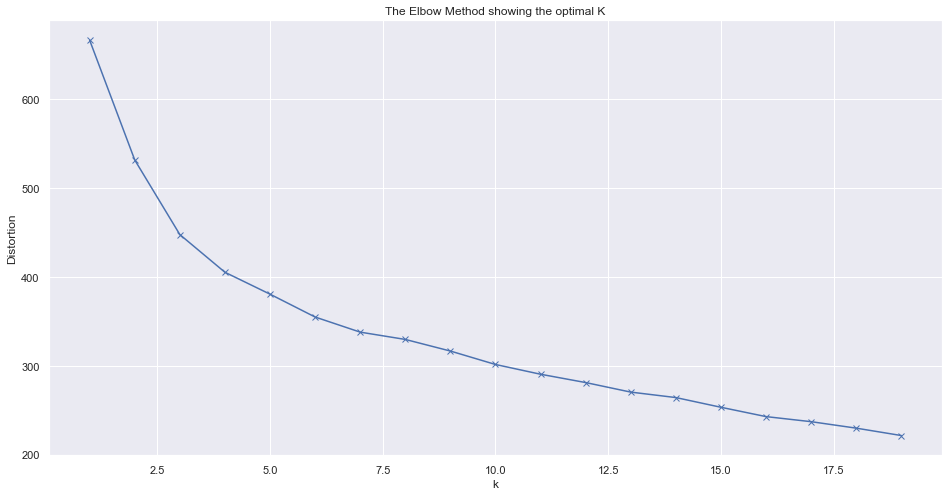

In [11]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal K')
plt.show()

<blockquote>
Looking at this graph it no quite clear as to what the optimal number of clusters are
</blockquote>

In [13]:
from kneed import KneeLocator
kl = KneeLocator(
range(1, 20), distortions, curve="convex", direction="decreasing"
)

kl.elbow

6

<blockquote>
I used the kneelocator to help me identify how many clusters I should use.
</blockquote>

In [14]:
kmeans = KMeans(n_clusters=6, random_state=1)
kmeans

KMeans(n_clusters=6, random_state=1)

In [15]:
kmodel = kmeans.fit_predict(X)


In [16]:
whiskey_df['class'] = kmodel
whiskey_df['class'].value_counts()

5    26
4    22
0    14
1    13
2     6
3     5
Name: class, dtype: int64

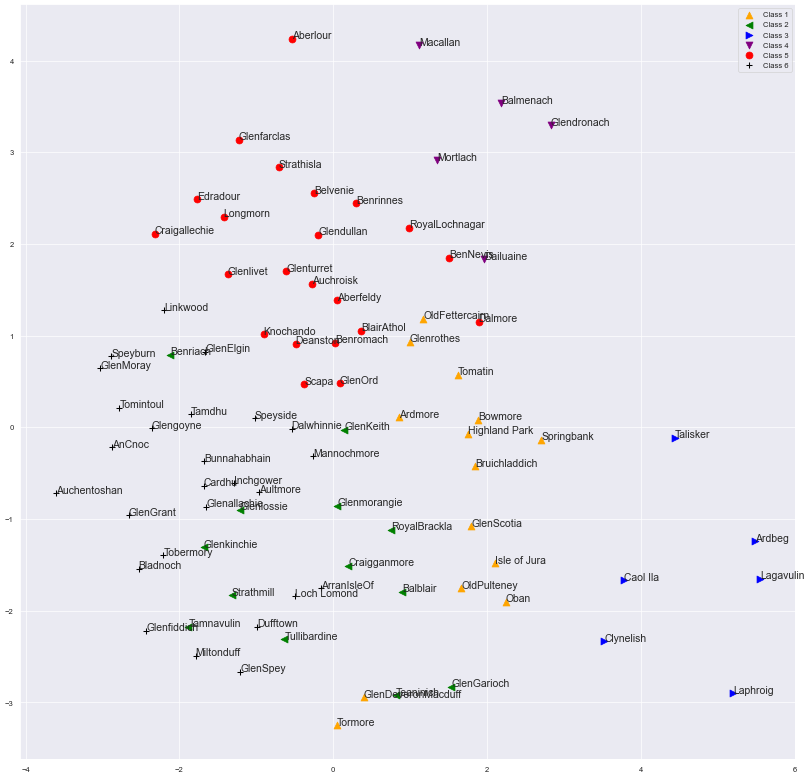

In [17]:
mds = manifold.MDS(n_components=2, dissimilarity="euclidean", random_state=0)
pos = mds.fit_transform(X)

col =['orange','green', 'blue', 'purple', 'red','black']
chars = "^<>vo+d"
c_flag = 0
labels = whiskey_df['Distillery']

plt.figure(figsize=(20, 20), dpi=50)
plt.rcParams["font.size"] = 15

for label, x, y, c in zip(labels, pos[:, 0], pos[:, 1],whiskey_df['class']):

    if(c == c_flag):
        c_flag = c_flag+1
        plt.scatter(x,y, c=col[c], marker=chars[c], s=100, label = "Class "+ str(c+1))
    else:
        plt.scatter(x,y, c=col[c], marker=chars[c], s=100)
        
    plt.annotate(label,xy = (x, y))
plt.legend(loc='upper right')
plt.show()

<blockquote>
From this we can see that distilleries within the same class are very closely positioned
    </blockquote>

In [18]:
map_whisky = folium.Map(location=[57.499520,  -2.776390], zoom_start = 10)

transformer = Transformer.from_crs('epsg:27700','epsg:4326')

for label, lon, lat, c in zip(labels, whiskey_df['Latitude'], whiskey_df['Longitude'], whiskey_df['class']):
    
    lat2,lon2 = transformer.transform(lon,lat)
    folium.Marker([lat2,lon2], popup= label, icon=folium.Icon(color=col[c])).add_to(map_whisky)

map_whisky

<blockquote>
    This graph shows the location of distilleries for each class. By clicking the markers, you can see the name of distilleries. From what we can see here the location doesn't have much of an impact on the type of whiskey.
    </blockquote>

<h2> Decision Tree </h2>
<blockquote>
    I'll be using a decision tree to identify the main differences between each cluster.
    </blockquote>

In [19]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state =1, min_samples_leaf=5)

X_train = X
y_train = whiskey_df['class']

tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=1)

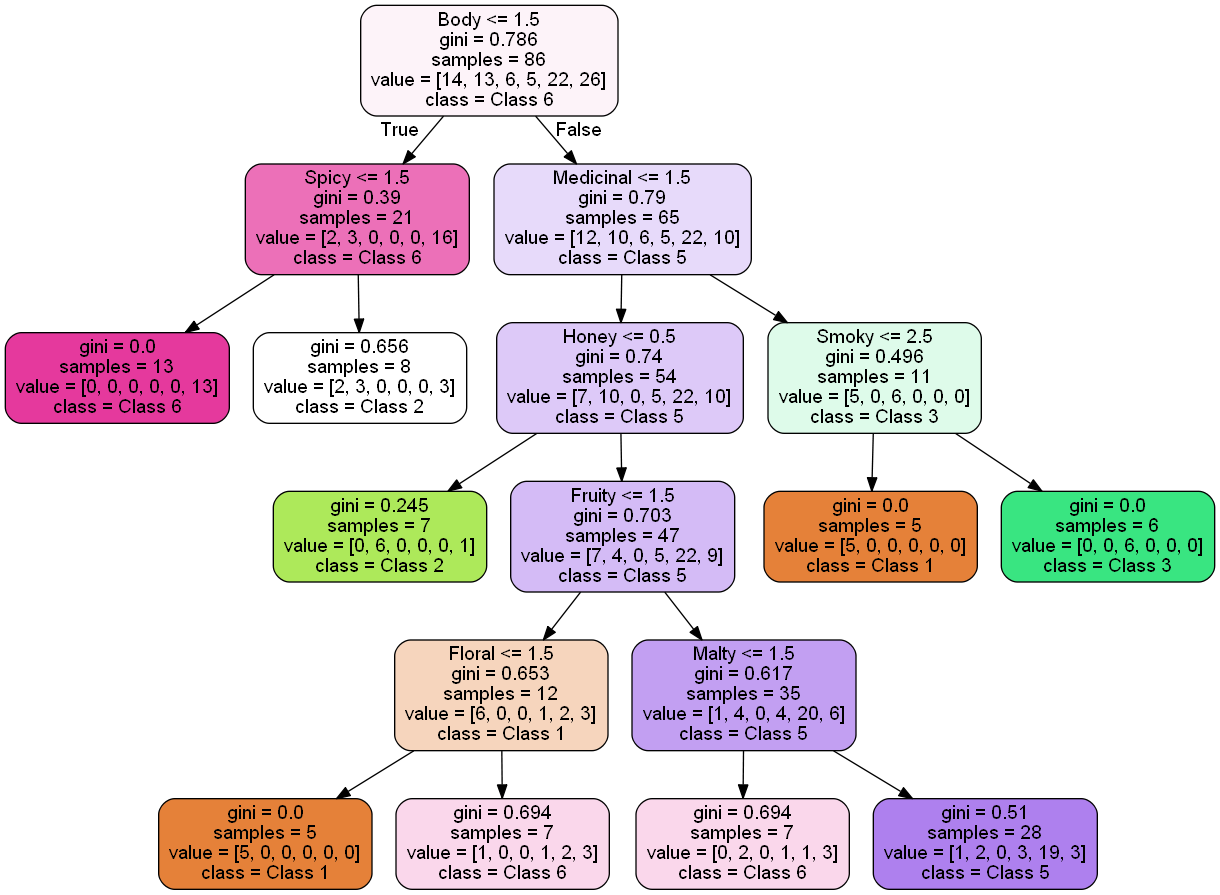

In [20]:
dot_data = export_graphviz(tree, filled = True, rounded = True, class_names = ['Class 1','Class 2', 'Class 3', 'Class 4', 'Class 5','Class 6'],
                          feature_names = ['Body', 'Sweetness', 'Smoky', 'Medicinal', 'Tobacco', 
                'Honey', 'Spicy', 'Winey', 'Nutty', 'Malty', 'Fruity', 'Floral'], out_file = None)

graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')
display_png(Image('tree.png'))

<blockquote>
    <ul>
<li> Class 1: Most of them are Body and Medicinal. Some being fruity and Honey</li>
 <li> Class 2: Most of them are Body, Medicinal and Honey.</li>
 <li> Class 3: Are body, medicinal and smokey.</li>
 <li> Class 4: Has and equal amount of samples that are Body Medicinal, Honey and Fruitty</li>
 <li> Class 5: Are Body Medicinal, Honey, Fruitty and Malty</li>
 <li> Class 6: Are mostly Body</li>
    </ul>
    </blockquote>